In [105]:
import pandas as pd
import numpy as np
import unidecode
import json
import string
from time import time
import re

%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from urlextract import URLExtract
from collections import defaultdict, Counter

from sklearn import metrics
from sklearn.utils.extmath import density
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/wardhuang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Loading files into dataframes

In [113]:
us_videos = pd.read_csv('./USvideos.csv')
ca_videos = pd.read_csv('./CAvideos.csv')
gb_videos = pd.read_csv('./GBvideos.csv')

In [114]:
us_videos.shape

(40949, 16)

In [115]:
ca_videos.shape

(40881, 16)

In [116]:
gb_videos.shape

(38916, 16)

In [117]:
us_videos.head(1)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...


Load the json categories into a python dictionary

In [118]:
def load_categories(fn):
    cat_str = "" # the json string

    with open(fn, 'r') as f:
        cat_str = f.read()
    
    # python dictionary
    cat_obj = json.loads(cat_str)

    # array of dictionaries
    cats_arr = cat_obj['items']

    # dataframe
    df = pd.json_normalize(cats_arr).convert_dtypes()

    # convert id to int
    df['id'] = pd.to_numeric(df['id'])

    # select just id and title
    df = df.loc[:,['id', 'snippet.title']]

    return df

In [125]:
us_cats = load_categories('./US_category_id.json')
ca_cats = load_categories('./CA_category_id.json')
gb_cats = load_categories('./GB_category_id.json')

In [136]:
ca_cats.shape

(31, 2)

In [137]:
gb_cats.shape

(31, 2)

Extra category in us categories

In [143]:
us_cats.shape

(32, 2)

There are 57 entries with that category as a label

In [153]:
us_videos[us_videos['category_id'] == 29].shape

(57, 16)

Merged categories (and drop category 29)

In [156]:
merged = us_cats.merge(ca_cats, on='id', suffixes=['_us', '_ca']).merge(gb_cats, on='id')

## Select columns from us_videos

We select the columns with identifying information, classification, and text descriptions

In [4]:
df_us = us_videos.loc[:,['title', 'channel_title', 'category_id', 'tags', 'description']].convert_dtypes()
df_us.tail(1)

,title,channel_title,category_id,tags,description
40948,Official Call of Duty®: Black Ops 4 — Multipla...,Call of Duty,20,"call of duty|""cod""|""activision""|""Black Ops 4""",Call of Duty: Black Ops 4 Multiplayer raises t...


In [5]:
df_usd = df_us.drop_duplicates(ignore_index=True)

print(df_usd.count(), "\n")

# merge on category_id
df_usd = df_usd.merge(us_cats, left_on='category_id', right_on='id')

# drop category_id
df_usd = df_usd.drop(['id', 'category_id'], axis=1)
df_usd = df_usd.rename(columns={"snippet.title": "category"})
df_usd.head(1)

title            7302
channel_title    7302
category_id      7302
tags             7302
description      7197
dtype: int64 



,title,channel_title,tags,description,category
0,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,SHANtell martin,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs


## Text Preprocessing

Things to consider removing:
- emails: `c.amber@gmail.com`
- normal urls: `http://facebook.com`
- other urls: `www.facebook.com`
- unicode: `\xa0`
- punctuation: `!"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
- numbers: `1234`
- nonsense: `PLvahqwMqN4M35d1XdbUEWZT_r36Z6tIz3`

In [6]:
en_stops = set([word.replace("'", '') for word in stopwords.words('english')])

# custom stop_words
custom_stops = set(["cant", "follow", "subscribe", "like", "comment"])

# terms to ignore
ignore = en_stops | custom_stops

# special characters to remove
specials = r'[' + re.escape(string.punctuation) + ']'

porter_stemmer = PorterStemmer()

In [7]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#### Cleaning the title?

In [8]:
def clean_title(s, stemming=True, min_length=0):
    
    # errors = oneof [ignore, preserve, replace]
    ss = unidecode.unidecode(s, errors='ignore')
    
    # replace dashes with empty space
    ss = ss.replace('-', ' ')

    ss = re.sub(specials, '', ss)
    
    words = ss.split(' ')
    
    words = [word.lower().strip() for word in words if len(word) > min_length and word not in ignore]
    
    if stemming:
        words = map(porter_stemmer.stem, words)
    
    return ' '.join(words)

In [9]:
%%time
titles = df_usd['title']
ctitles = titles.apply(clean_title, stemming=False)
ctitles_stem = titles.apply(clean_title, stemming=True)

CPU times: user 802 ms, sys: 9.28 ms, total: 811 ms
Wall time: 826 ms


In [10]:
titles[0]

'WE WANT TO TALK ABOUT OUR MARRIAGE'

In [11]:
ctitles[0]

'we want to talk about our marriage'

In [12]:
ctitles_stem[0]

'we want to talk about our marriag'

#### Cleaning the tags

In [13]:
def clean_tags(s, stemming=True, min_length=2):

    ss = s.replace('|', ' ')

    # errors = oneof [ignore, preserve, replace]
    ss = unidecode.unidecode(ss, errors='ignore')
    
    # replace dashes with empty space
    ss = ss.replace('-', ' ')

    ss = re.sub(specials, '', ss)

    words = ss.split(' ')

    words = [word.lower().strip() for word in words if len(word) > min_length and word not in ignore]

    if stemming:
        words = map(porter_stemmer.stem, words)

    return ' '.join(words)

In [14]:
%%time
tags = df_usd['tags']
ctags = tags.apply(clean_tags, stemming=False)
ctags_stem = tags.apply(clean_tags, stemming=True)

CPU times: user 3.69 s, sys: 7.05 ms, total: 3.69 s
Wall time: 3.7 s


In [15]:
tags[397]

'BuzzFeed|"BuzzFeedAsIs"|"BuzzFeed As/is"|"As/Is"|"asis"|"women try"|"women"|"try"|"one size fits all"|"bridesmaid"|"dress"|"bridesmaid dress"|"bridesmaid dresses"|"one size"|"fits all"|"wedding"|"bridesmaids"|"bridesmaids dress"|"bridesmaids dresses"|"wedding dress"|"bridal"|"best bridesmaid dresses"|"fashion"|"dresses"|"wedding planning"|"dress shopping"|"wedding style"|"dress ideas"|"review"|"plus size"|"BuzzFeedBoldly"|"BuzzFeed Boldly"|"Boldly"|"convertible dress"|"online shopping"'

In [16]:
ctags[397]

'buzzfeed buzzfeedasis buzzfeed asis asis asis women try women try one size fits bridesmaid dress bridesmaid dress bridesmaid dresses one size fits wedding bridesmaids bridesmaids dress bridesmaids dresses wedding dress bridal best bridesmaid dresses fashion dresses wedding planning dress shopping wedding style dress ideas review plus size buzzfeedboldly buzzfeed boldly boldly convertible dress online shopping'

In [17]:
ctags_stem[397]

'buzzfe buzzfeedasi buzzfe asi asi asi women tri women tri one size fit bridesmaid dress bridesmaid dress bridesmaid dress one size fit wed bridesmaid bridesmaid dress bridesmaid dress wed dress bridal best bridesmaid dress fashion dress wed plan dress shop wed style dress idea review plu size buzzfeedboldli buzzfe boldli boldli convert dress onlin shop'

#### Cleaning the description

In [18]:
extractor = URLExtract(extract_email=True)

In [19]:
def clean_desc(s, stemming=True, min_length=3):

    # Handle case of missing description
    if pd.isna(s):
        return ''

    # errors = oneof [ignore, preserve, replace]
    ss = unidecode.unidecode(s, errors='ignore')
    
    # replace newlines and dashes with empty space
    ss = re.sub(r'(' + re.escape("\\n") + ')|-', ' ', ss)

    # find and remove urls
    for url in extractor.find_urls(ss[::]):
        ss = re.sub(r'' + re.escape(url), '', ss)
    
    res = ss.split(' ')
    
    idx = 0
    for word in res[::]:
        # remove punctuation
        cword = re.sub(specials, '', word).strip().lower()
        if len(cword) > min_length and cword not in ignore:
            res[idx] = cword
            idx += 1

    if stemming:
        return ' '.join(map(porter_stemmer.stem, res[:idx]))
    else:
        return ' '.join(res[:idx])

In [20]:
%%time
desc = df_usd['description']
cdesc = desc.apply(clean_desc, stemming=False)
cdesc_stem = desc.apply(clean_desc, stemming=True)

CPU times: user 1min 45s, sys: 52.1 ms, total: 1min 45s
Wall time: 1min 45s


In [21]:
desc[28]
# desc[28] - dash

'Need I say more?'

In [22]:
cdesc[28]

'need'

In [23]:
cdesc_stem[28]

'need'

## Term Frequency

### Combine titles, tags, descriptions...

Let's find a good minimum document frequency

In [54]:
%%time

num_features = []

for min_df in range(1,20):
    count_vectorizer = CountVectorizer(max_df=0.5, min_df=min_df)
    combined = map(' '.join, zip(ctitles_stem, ctags_stem, cdesc_stem))
    combined_tf = count_vectorizer.fit_transform(combined)
    num_features.append(combined_tf.shape[1])

CPU times: user 8.77 s, sys: 32 ms, total: 8.8 s
Wall time: 8.8 s


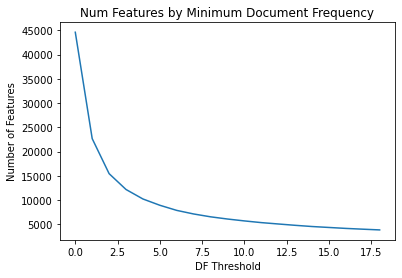

In [55]:
plt.plot(num_features)
plt.xlabel('DF Threshold')
plt.ylabel('Number of Features')
plt.title(f'Num Features by Minimum Document Frequency')
plt.show()

Elbow method? Try min_df of 4

In [92]:
combined = map(' '.join, zip(ctitles_stem, ctags_stem, cdesc_stem))
count_vectorizer = CountVectorizer(max_df=0.5, min_df=5)
combined_tf = count_vectorizer.fit_transform(combined)
combined_tf.shape

(7302, 10240)

In [93]:
feature_names = count_vectorizer.get_feature_names()

### Split into test / training

In [95]:
X_train, X_test, y_train, y_test = train_test_split(combined_tf,
                                                    df_usd['category'], test_size=0.3, random_state=8)

### Scale by IDF and L2 normalize

In [96]:
transformer = TfidfTransformer(norm='l2', use_idf=True, sublinear_tf=True)

In [97]:
X_train_tr = transformer.fit_transform(X_train)
X_train_tr.shape

(5111, 10240)

In [98]:
X_test_tr = transformer.transform(X_test)
X_test_tr.shape

(2191, 10240)

### Training

In [99]:
def benchmark(clf, print_cm=True):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train_tr, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test_tr)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))
        print()

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

In [100]:
benchmark(SGDClassifier(alpha=.0001, max_iter=100,
                                           penalty="elasticnet"))

________________________________________________________________________________
Training: 
SGDClassifier(max_iter=100, penalty='elasticnet')
train time: 0.639s
test time:  0.002s
accuracy:   0.819
dimensionality: 10240
density: 0.239563

confusion matrix:
[[ 12   0   0   2   0   0   0   0   0   0   0   0   8   2   0]
 [  0 165   0   9   1   0   2   3   1   0   4   2   0   0   0]
 [  2   1  74   5   1   0   2   1   2   0   0   0   3   0   0]
 [  0   9   3 471  11   1  17  16   5   0   9   1   3   3   0]
 [  0   2   0  32  52   0   3   2   1   0   5   0   3   0   1]
 [  0   1   1   2   0  34   0   0   0   0   0   0   0   0   0]
 [  0   0   0   8   0   0 164   1   1   0   7   0   2   0   0]
 [  0   1   0   9   3   0   0 281   1   0   4   0   1   0   0]
 [  0   0   1  11   0   0   0   0 146   0   4   2   4   2   0]
 [  0   0   0   1   0   0   0   0   0   1   0   0   1   0   0]
 [  1   5   0  40   1   0  13   7   5   0  90   2   8   6   0]
 [  0   0   0   3   1   0   0   0   1   0   0  49 

('SGDClassifier', 0.81926061159288, 0.6394355297088623, 0.0022377967834472656)

In [108]:
benchmark(LinearSVC())

________________________________________________________________________________
Training: 
LinearSVC()
train time: 0.350s
test time:  0.002s
accuracy:   0.825
dimensionality: 10240
density: 0.824695

confusion matrix:
[[ 12   0   0   3   0   0   0   0   0   0   0   0   7   2   0]
 [  0 167   0   8   1   0   1   4   1   0   3   2   0   0   0]
 [  2   2  74   5   0   0   2   1   1   0   0   0   4   0   0]
 [  0  10   1 472  10   1  18  16   4   0  11   1   3   2   0]
 [  0   2   0  29  56   0   2   3   1   0   5   0   2   0   1]
 [  0   1   0   4   0  33   0   0   0   0   0   0   0   0   0]
 [  0   0   0  10   0   0 165   1   1   0   4   0   1   0   1]
 [  0   1   0   8   4   0   0 282   0   0   4   0   1   0   0]
 [  0   1   0  13   0   0   1   0 144   0   3   2   4   2   0]
 [  0   0   0   1   0   0   0   0   0   1   0   0   1   0   0]
 [  1   3   0  41   2   0  13   7   3   0  94   2   6   5   1]
 [  0   0   0   2   1   0   0   0   1   0   2  48   0   1   0]
 [  1   0   2   8   2   0

('LinearSVC', 0.824737562756732, 0.35034608840942383, 0.0019042491912841797)

In [102]:
benchmark(MultinomialNB(alpha=.01))

________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01)
train time: 0.062s
test time:  0.004s
accuracy:   0.787
dimensionality: 10240
density: 1.000000

confusion matrix:
[[ 11   0   0   4   0   0   0   0   0   0   0   0   8   0   1   0]
 [  0 157   0  16   2   0   1   2   2   0   5   1   0   0   1   0]
 [  1   1  70   8   0   0   2   1   0   0   0   0   8   0   0   0]
 [  2  14   1 448   5   1  23  20   2   0  13   1  15   0   3   1]
 [  0   2   2  34  50   1   3   1   1   0   5   0   1   0   0   1]
 [  0   0   0   8   1  27   0   0   0   0   0   0   2   0   0   0]
 [  0   0   0  10   1   0 159   2   1   0   7   0   3   0   0   0]
 [  0   2   0  26   3   0   0 263   1   0   2   0   3   0   0   0]
 [  0   0   0  15   0   0   1   0 145   0   2   0   6   0   1   0]
 [  0   0   1   1   0   0   0   0   0   1   0   0   0   0   0   0]
 [  2   6   1  42   3   0  15   5   4   0  83   1   9   1   5   1]
 [  0   0   0   1   1   0   0 

/home/wardhuang/anaconda3/envs/255/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


('MultinomialNB',
 0.786855317206755,
 0.062064170837402344,
 0.003629446029663086)

In [103]:
benchmark(BernoulliNB(alpha=.01))

________________________________________________________________________________
Training: 
BernoulliNB(alpha=0.01)
train time: 0.029s
test time:  0.006s
accuracy:   0.769
dimensionality: 10240
density: 1.000000

confusion matrix:
[[ 10   0   0   4   0   0   0   0   0   0   1   0   8   1   0]
 [  1 146   0  14   1   3   1   3   1   0  14   1   0   2   0]
 [  2   0  69   6   0   0   1   1   0   0   2   0   7   3   0]
 [  2  23   1 404   6   3  22  32   2   0  29   4  16   4   1]
 [  1   0   0  18  53   2   3   5   4   0  12   0   2   0   1]
 [  0   1   0   3   1  31   0   0   1   0   0   0   1   0   0]
 [  0   0   0   8   0   1 144   1   1   0  25   0   3   0   0]
 [  0   1   0  11   2   0   0 277   1   0   5   0   3   0   0]
 [  0   0   0   5   0   1   1   1 151   0   4   2   3   2   0]
 [  0   0   0   0   1   0   0   0   1   1   0   0   0   0   0]
 [  3   1   1  25   2   5   8  16   6   0  99   0   6   5   1]
 [  0   0   0   1   1   0   0   3   0   0   7  41   0   2   0]
 [  2   0   2

/home/wardhuang/anaconda3/envs/255/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


('BernoulliNB', 0.7690552259242355, 0.028960704803466797, 0.0059356689453125)

In [104]:
benchmark(ComplementNB(alpha=.1))

________________________________________________________________________________
Training: 
ComplementNB(alpha=0.1)
train time: 0.095s
test time:  0.003s
accuracy:   0.784
dimensionality: 10240
density: 1.000000

confusion matrix:
[[  9   0   0   1   0   0   0   0   0   0   0   0  10   4   0]
 [  1 156   0  12   2   0   5   4   3   0   1   1   0   2   0]
 [  2   2  75   1   1   0   1   1   2   0   3   0   3   0   0]
 [  1  10   5 408   5   3  42  37   7   0   8   4  11   8   0]
 [  1   6   1  26  48   1   5   2   3   0   3   0   1   3   1]
 [  0   1   0   3   0  31   0   0   0   0   0   0   3   0   0]
 [  0   0   1   3   1   1 167   4   1   0   1   0   3   1   0]
 [  0   2   0   7   2   0   1 283   1   0   1   0   3   0   0]
 [  0   0   0   6   0   0   1   0 153   0   0   1   6   3   0]
 [  0   0   0   1   0   0   0   1   1   0   0   0   0   0   0]
 [  1   7   0  23   2   0  26  16   7   0  78   2   9   7   0]
 [  0   0   0   1   1   0   1   3   0   0   0  47   0   2   0]
 [  1   0   3

/home/wardhuang/anaconda3/envs/255/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


('ComplementNB',
 0.7836604290278412,
 0.09450340270996094,
 0.0026302337646484375)

## Extra code

In [35]:
def plotWf(dictionary, title, logscale=True):
    r"""Plot collection-wide word frequencies."""
    plt.plot(sorted(dictionary.values(), reverse=True))
    plt.xlabel('word')
    plt.ylabel('frequency')
    if logscale is True:
        plt.yscale('log')
        plt.ylabel('log(frequency)')
    plt.title(f'Corpus-wide word frequency distribution ({title})')
    plt.show()

def plotDf(dataframe, title, logscale=False):
    r"""Plot collection-wide document-word frequencies."""
    # document word frequency
    df = defaultdict(int)
    for word, col in dataframe.iterrows():
        df[word] += len(col.dropna())

    plt.plot(sorted(df.values(), reverse=True))
    plt.xlabel('word')
    plt.ylabel('frequency')
    if logscale is True:
        plt.yscale('log')
        plt.ylabel('log(frequency)')
    plt.title(f'Corpus-wide document-word frequency distribution ({title})')
    plt.show()

### Tags

In [117]:
%%time
df_tags, tag_terms = tf_vectorize(ctags_stem)

CPU times: user 20.6 s, sys: 1.06 s, total: 21.6 s
Wall time: 21.2 s


In [118]:
df_tags.shape

(7302, 20079)

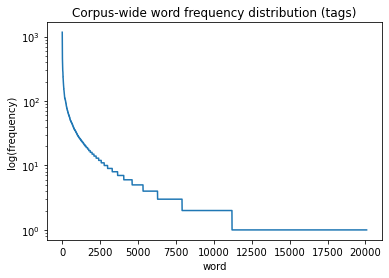

In [119]:
plotWf(tag_terms, 'tags', logscale=True)

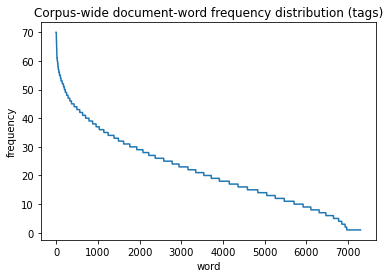

In [120]:
plotDf(df_tags, 'tags', logscale=False)

#### Description

In [121]:
%%time
df_desc, desc_terms = tf_vectorize(cdesc_stem)

CPU times: user 56.7 s, sys: 1.97 s, total: 58.7 s
Wall time: 58 s


In [122]:
df_desc.shape

(7302, 39064)

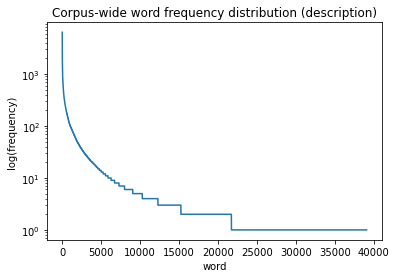

In [123]:
plotWf(desc_terms, 'description', logscale=True)

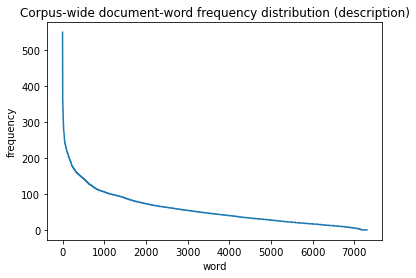

In [124]:
plotDf(df_desc, 'description', logscale=False)

#### Overlapping terms

In [125]:
overlap = set(tag_terms.keys()) & set(desc_terms.keys())
union = set(tag_terms.keys()) | set(desc_terms.keys())
print(f'{len(overlap)} overlapping terms')
print(f'{len(union)} unique terms across tags & descriptions')

13189 overlapping terms
45954 unique terms across tags & descriptions


## Feature Importance

In [20]:
d = defaultdict(set) # channel_title: category_id
for row in df_usd.itertuples():
    d[row.channel_title].add(row.category_id)

dl = [len(val) for val in d.values()]
print(f'Number of unique youtube videos (US): {len(df_usd)}')
print(f'Number of unique channels: {len(d)}')
print(f'Max # of unique categories for a channel: {max(dl)}')
print(f'Average # of unique categories per channel: {sum(dl) / len(dl)}')

Number of unique youtube videos (US): 7302
Number of unique channels: 2207
Max # of unique categories for a channel: 7
Average # of unique categories per channel: 1.0693248753964657
